In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from bt_tools import get_df_stoxx, performance_analysis, trend_follow_sigs
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
import re
import pandas as pd
import numpy as np
import json
import yfinance as yf

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1


In [4]:
df = pd.read_pickle('closes_sp500_2020-09-15.pkl') # temp_close_stoxx600

df.ffill(inplace=True)
df.dropna(how='all', axis=1, inplace=True)

df.sort_index(inplace=True)
today = pd.datetime.today().date()

## Since you can't run this
# df = df[today - pd.Timedelta('6Y'):]


df = df["-".join([str(today.year-6), str(today.month), str(today.day)]):]


## Data Quality issue
# df.loc['2020-07-22', 'CRDA.L'] = 5616.00

## Rerun all cells to modify weekly transaction cost (return based)
transaction_cost =  0.000 #0.0010

/Users/kingf.wong/.conda/envs/FinanceML/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [5]:
df

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-15,41.430614,37.070000,133.990005,25.407499,57.930000,76.839996,24.670000,42.720001,80.599998,70.269997,...,41.970001,96.290001,46.630001,35.309616,37.180000,51.574406,104.489998,73.500000,29.450001,36.270000
2014-09-16,41.423462,37.980000,135.419998,25.215000,58.599998,77.110001,24.850000,42.900002,80.089996,70.730003,...,43.230000,97.430000,46.570000,36.100132,37.509998,51.754135,104.940002,74.769997,29.190001,36.490002
2014-09-17,42.124462,37.459999,134.369995,25.395000,59.619999,76.529999,25.180000,43.380001,79.680000,67.300003,...,43.919998,97.080002,46.570000,36.627140,37.400002,52.063263,103.970001,74.540001,29.530001,36.650002
2014-09-18,41.773964,38.049999,133.619995,25.447500,59.450001,77.129997,25.430000,43.689999,80.459999,67.910004,...,44.470001,96.610001,46.700001,36.574440,37.770000,52.221424,104.250000,75.410004,29.870001,36.700001
2014-09-19,41.666668,36.630001,131.759995,25.240000,59.060001,77.330002,25.350000,43.590000,79.930000,66.940002,...,44.090000,97.120003,46.599998,36.837944,37.770000,52.465851,103.989998,74.089996,30.010000,37.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-09,97.930000,13.050000,154.350006,117.320000,91.629997,96.199997,277.929993,105.809998,238.910004,479.459991,...,100.389999,37.950001,44.230000,19.010000,83.410004,93.389999,140.199997,255.110001,32.119999,158.910004
2020-09-10,98.570000,13.010000,153.559998,113.489998,89.650002,94.269997,272.019989,104.000000,233.649994,476.260010,...,98.800003,37.000000,43.720001,18.629999,82.019997,92.349998,138.669998,249.440002,31.120001,158.100006
2020-09-11,98.599998,12.950000,154.589996,112.000000,89.699997,94.080002,269.769989,104.699997,234.770004,471.350006,...,98.650002,36.900002,44.160000,19.090000,84.550003,92.269997,139.210007,249.960007,31.490000,158.589996


In [7]:
## Construct Signals
df_20MA = df.rolling(20).mean().fillna(0)
df_50MA = df.rolling(50).mean().fillna(0)
df_150MA = df.rolling(150).mean().fillna(0)

## Since you can't run this
# stoxx600 = pd.read_pickle('stoxx600.pkl')['Close'][today - pd.Timedelta('5Y'):]

five_yrs_ago_date = "-".join([str(today.year-5), str(today.month), str(today.day)])
sp500 = yf.Ticker('SPY')
sp500 = sp500.history(period="max")['Close'][five_yrs_ago_date:]


ret_sp500 = sp500.pct_change().fillna(0)
eq_curve_sp500 = (ret_sp500+ 1).cumprod()


## Requested Portfolio
## Long trend following, short index
## equal weighted in stocks, and long short


binary_signal = (df_20MA > df_50MA)&(df_50MA>df_150MA)
ret_df = df[five_yrs_ago_date:].pct_change(1).fillna(0)

arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)


holdings = binary_signal.shift(1)[five_yrs_ago_date:]
w = holdings.sum(axis=1)
w=(1/w).replace([np.inf, -np.inf], 0)


port_ret = ((ret_df*holdings.mul(w, axis='index')).sum(axis=1) - pd.Series(arr_transaction_cost, index=w.index)).rename('Long').to_frame()
port_ret['Short'] = ret_sp500

port_ret = port_ret.fillna(0)

ew_eq_curve = (port_ret+1).cumprod()


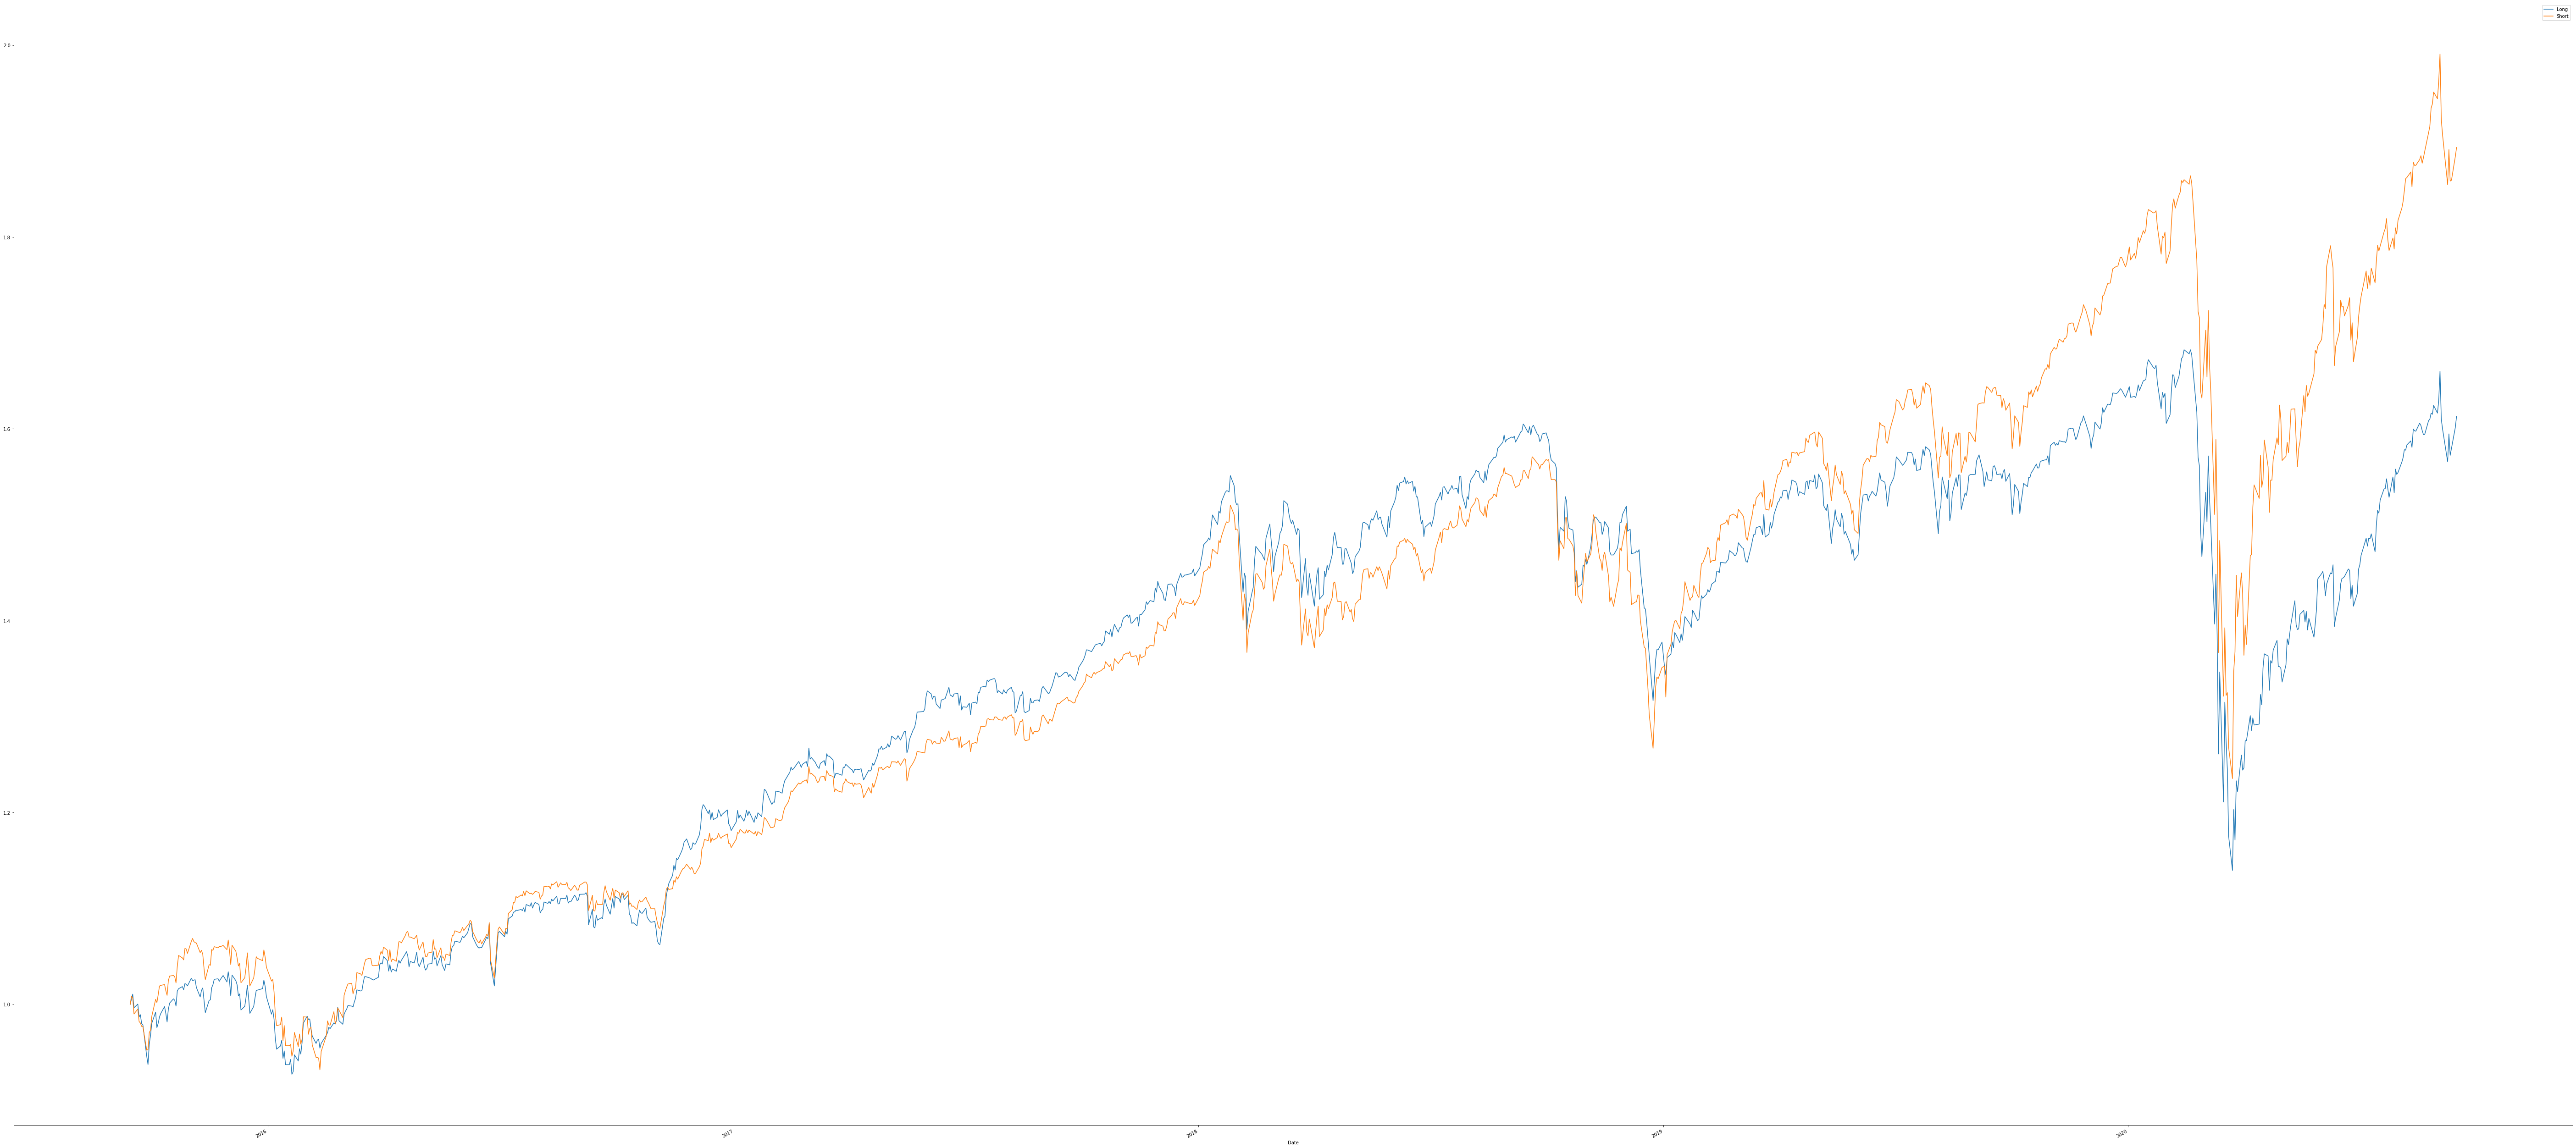

In [8]:
## Long/ Short Side Plot
ew_eq_curve.plot(figsize=(100,50), legend=True)
plt.show()
plt.close()

In [ ]:
## combined PnL

combined_PnL = (port_ret['Long'] - port_ret['Short'] + 1).cumprod()
combined_PnL.plot(figsize=(100,50), legend=True)

plt.show()
plt.close()

In [ ]:
combined_PnL.pct_change(1).skew()

In [ ]:
combined_PnL.pct_change(1).describe()

In [ ]:
performance_analysis(combined_PnL, (port_ret['Short'] + 1).cumprod(), port_name="Original Portfolio")

In [ ]:
## what if we seperate the two trend trading rules, what the portfolio will look like?
signal_20_50 = df_20MA - df_50MA
signal_50_150 = df_50MA - df_150MA


holdings_20_50 = np.sign(signal_20_50).replace(-1, 0)[five_yrs_ago_date:]
holdings_50_150 = np.sign(signal_50_150).replace(-1, 0)[five_yrs_ago_date:]

w_20_50 = (1/holdings_20_50.sum(axis=1)).replace([np.inf, -np.inf], 0)
w_50_150 = (1/holdings_50_150.sum(axis=1)).replace([np.inf, -np.inf], 0)


arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)


port_ret_20_50 = ((ret_df*holdings_20_50.mul(w_20_50, axis='index')).sum(axis=1) - ret_stoxx600 - pd.Series(arr_transaction_cost, index=w.index)).fillna(0)
port_ret_50_150 = ((ret_df*holdings_50_150.mul(w_50_150, axis='index')).sum(axis=1) - ret_stoxx600 - pd.Series(arr_transaction_cost, index=w.index)).fillna(0)
            
            
ew_eq_curve_20_50 = (port_ret_20_50+1).cumprod()
ew_eq_curve_50_150 = (port_ret_50_150+1).cumprod()


In [ ]:
len([0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5))

In [ ]:
ew_eq_curve_20_50_150 = ew_eq_curve_20_50.rename('20_50').to_frame()
ew_eq_curve_20_50_150['50_150'] = ew_eq_curve_50_150
ew_eq_curve_20_50_150["original"] = combined_PnL


In [ ]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True, title="Portfolios PnLs of Seperated Signals")
plt.show()
plt.close()


We also discovered a most likely data quality issue, from yahoo finance
seems like two decimal points are missing for CRDA.L
We'll edit it for now and rerun previous analysis







In [ ]:
performance_analysis(ew_eq_curve_20_50_150['20_50'], (port_ret['Short'] + 1).cumprod(), port_name="20_50 Signal")


In [ ]:
performance_analysis(ew_eq_curve_20_50_150['50_150'], (port_ret['Short'] + 1).cumprod(), port_name="50_150 Signal")

In [ ]:
sep_signal_ret = port_ret_20_50.rename('20_50').to_frame()
sep_signal_ret['50_150'] = port_ret_50_150

In [ ]:
## The returns of the trading are plagued by outliers
sns.jointplot(sep_signal_ret['20_50'],sep_signal_ret['50_150'])

In [ ]:
## Can remove the outliers by winsorizing 
sep_signal_ret = pd.DataFrame(mstats.winsorize(sep_signal_ret, [0.05, 0.05]), index=sep_signal_ret.index, columns=sep_signal_ret.columns)

In [ ]:
sns.jointplot(sep_signal_ret['20_50'],sep_signal_ret['50_150'])

In [ ]:
sep_signal_ret.corr()

In [ ]:
def compute_MV_weights(cov_m):
    inv_covar = np.linalg.inv(cov_m)
    u = np.ones(len(cov_m))
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))

In [ ]:
## adjust by price volatility, so big moves of slow movers weight more than big moves of big movers
std_df = ret_df.rolling(60).std()
price_vol = df*std_df

In [ ]:
## try to build different portfolios to see if there's improvement with different weighting scheme


signal_20_50 = df_20MA - df_50MA
signal_50_150 = df_50MA -df_150MA

norm_signal_20_50 = ((signal_20_50)/price_vol).replace([np.inf, -np.inf, np.nan],0)
norm_signal_50_150 = ((signal_50_150)/price_vol).replace([np.inf, -np.inf, np.nan],0)

## we can weight the two signals by inversing the covariance matrix of the seperated portfolio returns, will ignore insample calculation for now


w_trading_rules = compute_MV_weights(sep_signal_ret.cov())
w_trading_rules

In [ ]:
combined_signal = norm_signal_20_50*w_trading_rules[0] + norm_signal_50_150*w_trading_rules[1]

In [ ]:
combined_signal.describe()

In [ ]:
def simple_ew_backtester(bt_signal_df, bt_ret_df, b_ret, rules=0, transaction_cost=transaction_cost):
    
    bt_signal_df = bt_signal_df.where(bt_signal_df < rules,np.inf)
    bt_signal_df = bt_signal_df.where(bt_signal_df > rules,np.nan)
    bt_signal_df = bt_signal_df.replace(np.inf,1).fillna(0)

    bt_holdings = bt_signal_df.shift(1)[five_yrs_ago_date:]
    bt_w = (1/bt_holdings.sum(axis=1)).replace([np.inf, -np.inf], 0)


    arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)
    
    
    
    bt_port_ret = (bt_ret_df*holdings.mul(bt_w, axis='index')).sum(axis=1) - b_ret - pd.Series(arr_transaction_cost, index=w.index)
    bt_ew_eq_curve = (bt_port_ret.fillna(0)+1).cumprod()
    

    return bt_port_ret, bt_ew_eq_curve
    
    
    
    
    

In [ ]:
combined_ew_ret_0, combined_ew_eq_curve_0 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=0, transaction_cost=transaction_cost)
combined_ew_ret_1, combined_ew_eq_curve_1 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=1, transaction_cost=transaction_cost)
combined_ew_ret_2, combined_ew_eq_curve_2 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=2, transaction_cost=transaction_cost)

In [ ]:

ew_eq_curve_20_50_150['ew_mv_signal_0'] = combined_ew_eq_curve_0
ew_eq_curve_20_50_150['ew_mv_signal_1'] = combined_ew_eq_curve_1
ew_eq_curve_20_50_150['ew_mv_signal_2'] = combined_ew_eq_curve_2

In [ ]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True, title="Portfolios PnLs of Combined Continuous Signals")
plt.show()
plt.close()

In [ ]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_0'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 0")

In [ ]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_1'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 1")

In [ ]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_2'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 2")

In [ ]:
def simple_mv_backtester(bt_signal_df, ret_df, min_periods=20, rules=1.645):
    
    bt_signal_df = bt_signal_df.where(bt_signal_df < rules,np.inf)
    bt_signal_df = bt_signal_df.where(bt_signal_df > rules,np.nan)
    bt_signal_df = bt_signal_df.replace(np.inf,1).dropna(how='all', axis=1).fillna(0)
    bt_holdings = bt_signal_df.shift(1)[five_yrs_ago_date:]
    
    bt_ret_df = ret_df*bt_holdings
    bt_ret_df = ret_df.replace(-0,0)

    
    ## to avoid sigular matrix error due to zero prices returns, adding tiny tiny nois to the covariance matrix
    noised_bt_ret_df = bt_ret_df+0.00000001*np.random.rand(*bt_ret_df.shape)
    noised_bt_ret_df = noised_bt_ret_df.dropna(how='all', axis=1).fillna(0)
    cov_df = noised_bt_ret_df.expanding( min_periods=min_periods).cov().dropna(axis=0) # window=min_periods,
    

    w_MV = cov_df.groupby(level=0, axis=0).apply(compute_MV_weights).apply(pd.Series)
    
    w_MV.columns = cov_df.columns
    
    bt_port_ret = (bt_ret_df.mul(w_MV, axis='index').fillna(0)).sum(axis=1) 
    bt_mv_eq_curve = (bt_port_ret.fillna(0)+1).cumprod()
    

    return bt_port_ret, bt_mv_eq_curve
    
    
    

In [ ]:
mv_port_ret_2, mv_eq_curv_2 = simple_mv_backtester(combined_signal, ret_df, rules=2)


In [ ]:
mv_eq_curv_2.plot(figsize=(100,50), legend=True,title="Portfolio PnL of Minimum Variance Portfolio")
plt.show()
plt.close()

In [ ]:
ew_eq_curve_20_50_150['MV_port_2'] = mv_eq_curv_2

In [ ]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True,title="All Portfolios PnLs")
plt.show()
plt.close()

In [ ]:
performance_analysis(ew_eq_curve_20_50_150['MV_port_2'], (port_ret['Short'] + 1).cumprod(), port_name="Min. Variance threshold 0")